# ==================================================
# S1 (Direct Strategy)
# M1 (CAT)
# Standard Code _ Version 2.5 / KISLAB @ Kookmin University
# ==================================================

# Load Library

In [14]:
# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Regression
from xgboost import XGBRegressor

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
import tensorflow as tf

import datetime
import sys

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras


# Basic Options (for Extended Experiment)

In [15]:
# 기본 설정값
SMCODE = "COMPETITION"  # S1(Direct Strategy) + M1(LGBM) 를 위한 Standard Code
PDCODE = "CITY"  # 품종코드
MDCODE = "XGB"  # 모델코드
PDNAME = "gumi"  # 품종명(영문)
VARS = 1  # 확장변수 사용여부 (1: 가격만 사용, 2: 거래량 추가사용)

# 학습 기본변수 설정
PARAMS = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbose": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
          }
ITER = 2500  # LGBM의 학습 반복 횟수

# Special Option 설정
FRAC = 0  # 검증기간 데이터 중 학습 데이터에 추가로 포함시킬 데이터의 비중 (0~1)
# 만약 테스트 데이터를 검증용으로 사용하고 싶다면, FRAC = 1로 설정한 뒤, SPLIT을 테스트 데이터 관측건수(D1은 365, D2는 210)으로 설정
IRANGE = 365  # 가격 데이터를 입력으로 사용할 때 최대 총 며칠치 데이터를 사용할 것인지에 대한 옵션
SPLIT = 0  # 이 값을 0으로 설정할 경우, validation 수행하지 않음
WINSOR = 10  # 이상치 제거를 위한 Winsorizing 기준 설정 (단위: 퍼센트 / 이 값이 0일 경우, 이상치 제거 안함)

# 검증기간 설정
TEST_PERIOD = 1  # 1을 입력하면 D1으로 기간이 설정되고, 2로 지정하면 D2로 기간 설정

if TEST_PERIOD == 1:
    BASEDATE = '2020-12-31'  # 검증용 데이터의 시작 시점 (D1을 위한 설정)
    USEDATE = '2021-12-31'  # 전체 사용할 데이터의 마지막 시점 (D1을 위한 설정)
else:
    BASEDATE = '2022-01-01'  # 검증용 데이터의 시작 시점 (D2를 위한 설정)
    USEDATE = '2022-07-31'  # 전체 사용할 데이터의 마지막 시점 (D2를 위한 설정)

SELECTED = [336]  # 예측모델을 개발할 선택 시점
NSEL = len(SELECTED)  # 예측모델을 개발할 선택 시점의 총 갯수

# ========= 결과 저장용 폴더 생성 ==============

# System related and data input controls
import os

MODEL_DIR = 'MODEL_' + PDCODE + '_' + SMCODE + 'V' + str(VARS) + '_' + MDCODE

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(f'{MODEL_DIR}')

# ============= 데이터셋 로드 ================

# Ignore the warnings
import warnings

#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd

#load data
train = pd.read_csv('data_tr_city.csv', usecols=['datetime','구미 혁신도시배수지 유출유량 적산차'])
test = pd.read_csv('data_ts_city.csv', usecols=['datetime','구미 혁신도시배수지 유출유량 적산차'])

# train = train[train['품종']=='양파(일반)']
#create 'datetime' column
# if '일자' in train.columns:
#     train['일자'] = pd.to_datetime(train['일자'])
# train['datetime'] = pd.to_datetime(train['datetime'])

#set datetime to index
# if train.index.dtype == 'int64':
#     train.set_index('datetime', inplace=True)

# train.drop(['품종', '일자'], axis=1, inplace=True)
# train.columns = ['Price', 'Volume']
# for i in range(0, train.shape[0]):
#     train['Volume'][i] = train['Volume'][i].replace(',','')
# train['Volume'] = train['Volume'].astype('float32')

#fill missing date & values
# train.asfreq('H')[train.asfreq('H').isnull().sum(axis=1) > 0]
# train = train.asfreq('H', method='ffill')


In [16]:
train = train.rename(columns={"구미 혁신도시배수지 유출유량 적산차": "Price"})
train.drop(index= [17558, 2127], inplace=True)
train.drop(index=11995, inplace=True)

train.dropna(inplace=True)
train["Price"] = train["Price"].astype(int)

drop_table = train.iloc[:,1].value_counts().sort_values() ==1
#drop table 생성
drop_table = drop_table.reset_index(name="drop")
drop_table = drop_table.rename(columns=  {"index":"Price"})
test = pd.merge(train, drop_table, how='left', on = "Price")
drop_table = test["drop"]
train = test.loc[~drop_table]
train.drop(columns="drop", inplace= True)
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')
train.set_index('datetime', inplace=True, drop=True)
train["Price"] = train.loc[:,"Price"].astype(int)

train = train.asfreq(freq='H',method='ffill')
# 제거되었던 91(80+11)개의 결측값이 ffill(과거값)을 통해 새로 작성됨
#총 35063개의 row

In [17]:
test = test.rename(columns={"구미 혁신도시배수지 유출유량 적산차": "Price"})

test.dropna(inplace=True)
test["Price"] = test["Price"].astype(int)


test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S')
test.set_index('datetime', inplace=True, drop=True)
test["Price"] = test.loc[:,"Price"].astype(int)

# 제거되었던 91(80+11)개의 결측값이 ffill(과거값)을 통해 새로 작성됨
#총 35063개의 row

# Data Partitioning

In [61]:
# Raw dataset selection
# raw = raw[raw.index <= USEDATE]

# Train,Test split
# test = raw[raw.index >= BASEDATE]
# train = raw[raw.index < BASEDATE]
# raw_idx = raw.index
# train_idx = train.index

In [23]:
train_new

,Price,Price_336lag,Price_337lag,Price_338lag,Price_339lag,Price_340lag,Price_341lag,Price_342lag,Price_343lag,Price_344lag,Price_345lag,Price_346lag,Price_347lag,Price_348lag,Price_349lag,Price_350lag,Price_351lag,Price_352lag,Price_353lag,Price_354lag,...,Price_681lag,Price_682lag,Price_683lag,Price_684lag,Price_685lag,Price_686lag,Price_687lag,Price_688lag,Price_689lag,Price_690lag,Price_691lag,Price_692lag,Price_693lag,Price_694lag,Price_695lag,Price_696lag,Price_697lag,Price_698lag,Price_699lag,Price_700lag
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-30 05:00:00,34,34.00,34.00,40.00,119.00,238.00,459.00,358.00,133.00,138.00,273.00,188.00,336.00,125.00,198.00,67.00,160.00,143.00,439.00,187.00,...,245.00,202.00,199.00,132.00,148.00,141.00,181.00,250.00,203.00,243.00,114.00,392.00,187.00,34.00,34.00,34.00,34.00,128.00,237.00,138.00
2017-01-30 06:00:00,42,34.00,34.00,34.00,40.00,119.00,238.00,459.00,358.00,133.00,138.00,273.00,188.00,336.00,125.00,198.00,67.00,160.00,143.00,439.00,...,308.00,245.00,202.00,199.00,132.00,148.00,141.00,181.00,250.00,203.00,243.00,114.00,392.00,187.00,34.00,34.00,34.00,34.00,128.00,237.00
2017-01-30 07:00:00,133,91.00,34.00,34.00,34.00,40.00,119.00,238.00,459.00,358.00,133.00,138.00,273.00,188.00,336.00,125.00,198.00,67.00,160.00,143.00,...,152.00,308.00,245.00,202.00,199.00,132.00,148.00,141.00,181.00,250.00,203.00,243.00,114.00,392.00,187.00,34.00,34.00,34.00,34.00,128.00
2017-01-30 08:00:00,203,110.00,91.00,34.00,34.00,34.00,40.00,119.00,238.00,459.00,358.00,133.00,138.00,273.00,188.00,336.00,125.00,198.00,67.00,160.00,...,197.00,152.00,308.00,245.00,202.00,199.00,132.00,148.00,141.00,181.00,250.00,203.00,243.00,114.00,392.00,187.00,34.00,34.00,34.00,34.00
2017-01-30 09:00:00,34,178.00,110.00,91.00,34.00,34.00,34.00,40.00,119.00,238.00,459.00,358.00,133.00,138.00,273.00,188.00,336.00,125.00,198.00,67.00,...,175.00,197.00,152.00,308.00,245.00,202.00,199.00,132.00,148.00,141.00,181.00,250.00,203.00,243.00,114.00,392.00,187.00,34.00,34.00,34.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,328,322.00,142.00,237.00,307.00,383.00,336.00,336.00,344.00,158.00,138.00,388.00,188.00,279.00,89.00,66.00,58.00,64.00,157.00,216.00,...,459.00,459.00,268.00,97.00,53.00,48.00,54.00,67.00,147.00,172.00,165.00,188.00,459.00,395.00,412.00,272.00,115.00,138.00,193.00,191.00
2020-12-31 20:00:00,347,286.00,322.00,142.00,237.00,307.00,383.00,336.00,336.00,344.00,158.00,138.00,388.00,188.00,279.00,89.00,66.00,58.00,64.00,157.00,...,353.00,459.00,459.00,268.00,97.00,53.00,48.00,54.00,67.00,147.00,172.00,165.00,188.00,459.00,395.00,412.00,272.00,115.00,138.00,193.00
2020-12-31 21:00:00,335,377.00,286.00,322.00,142.00,237.00,307.00,383.00,336.00,336.00,344.00,158.00,138.00,388.00,188.00,279.00,89.00,66.00,58.00,64.00,...,258.00,353.00,459.00,459.00,268.00,97.00,53.00,48.00,54.00,67.00,147.00,172.00,165.00,188.00,459.00,395.00,412.00,272.00,115.00,138.00


# XGB without FE

  0%|          | 0/1 [00:00<?, ?it/s]

[15:43:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


gumi / XGB / Model336 Training Result



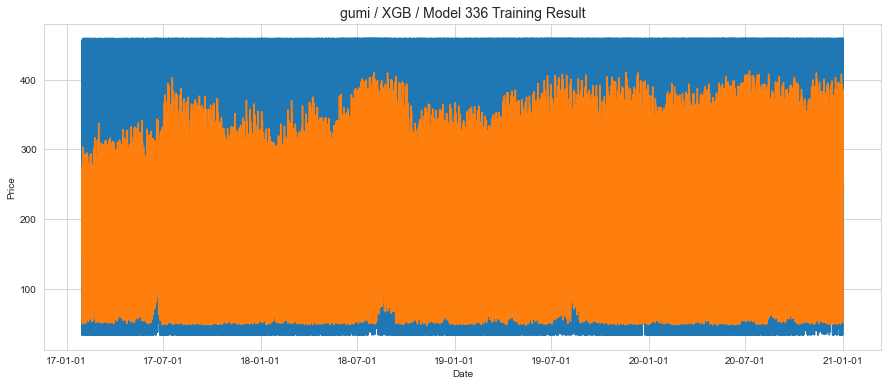

100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


<Figure size 432x288 with 0 Axes>

In [20]:
pred = []

with tf.device("/device:GPU:0"):  # GPU 활용이 불가능한 경우, CPU로 설정

    for day_num in tqdm(SELECTED):

        train_all = []
        train_all = train.iloc[:, :2]

        # Price에 Outlier Treatment 적용 ---------------------#

        winsor_list = []
        winsor_list.append(WINSOR)
        winsor_list.append(100 - WINSOR)

        winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
        winsor_min = winsors[0]
        winsor_max = winsors[1]

        train_all['Price'][train_all.index < BASEDATE] = np.where(
            train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min,
            train_all['Price'][train_all.index < BASEDATE])
        train_all['Price'][train_all.index < BASEDATE] = np.where(
            train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max,
            train_all['Price'][train_all.index < BASEDATE])

        #-----------------------------------------------------#

        for i in range(day_num, IRANGE + day_num):
            train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

        if VARS == 2:  # 거래량을 사용할 경우에만 처리

            for i in range(day_num, IRANGE + day_num):
                train_all[f'Volume_{i}lag'] = train_all['Volume'].shift(i)
            train_all = train_all.drop(['Volume'], axis=1)

        # else:
            # train_all = train_all.drop(['Volume'], axis=1)

        train_all = train_all.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

        train_old = train_all[train_all.index < BASEDATE]
        test_new = train_all[train_all.index >= BASEDATE]

        # 검증기간 데이터 FRAC 추가  ---------------------#

        train_new = train_old.append(test_new.sample(frac=FRAC))
        #
        y_train_raw = train_new['Price']
        x_train_raw = train_new.drop(['Price'], axis=1)

        #-----------------------------------------------------#

        # Min-Max Normalization 적용
        scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0, 1))
        X_train = scaler_X_tr.fit_transform(x_train_raw)

        # Validation 데이터을 학습에 사용할 경우에 대한 처리

        if SPLIT == 0:
            x_train = X_train
            y_train = y_train_raw
        else:
            x_train = X_train[:-SPLIT]
            y_train = y_train_raw[:-SPLIT]
            x_valid = X_train[-SPLIT:]
            y_valid = y_train_raw[-SPLIT:]

            dvalid = lgb.Dataset(x_valid, label=y_valid)

        # LGBM Training

        # dtrain = lgb.Dataset(x_train, label=y_train)

        params_xgb = {
            'max_depth':4,
            # 'learning_rate':0.05,
            #               'subsample':0.8,
            #               'colsample_bytree':0.6,
                          'eval_metric':'logloss',
            #               'object': 'reg:squarederror',
            #               'tree_method':'gpu_hist',
            #               'predictor':'gpu_predictor',
            'num_leaves': 555,
            # 'min_child_weight': 0.034,
            # 'feature_fraction': 0.379,
            # 'bagging_fraction': 0.418,
            # 'min_data_in_leaf': 106,
            # 'objective': 'regression',
            # 'max_depth': -1,
            'learning_rate': 0.05,
            # "boosting_type": "gbdt",
            # "bagging_seed": 11,
            # "metric": 'rmse',
            # "verbose": -1,
            # 'reg_alpha': 0.3899,
            # 'reg_lambda': 0.648,
            # 'random_state': 222,

        }

        xgb_model = XGBRegressor(
            **params_xgb
            , random_state=222
        )
        if SPLIT == 0:
            model = xgb_model.fit(x_train, y_train)

        else:
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER, valid_sets=dvalid, verbose_eval=False)

        # Save model
        joblib.dump(model, f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}woFE_{day_num}.pkl')

        # 학습한 결과의 예측모델 출력  ---------------------#

        y_train_real = train_old['Price']
        x_train_pred = scaler_X_tr.fit_transform(train_old.drop(['Price'], axis=1))
        y_train_pred = model.predict(x_train_pred)

        print(f'{PDNAME} / {MDCODE} / Model{day_num} Training Result\n')

        plot_data = pd.concat(
            [pd.DataFrame(y_train_real.values, columns=['actual']), pd.DataFrame(y_train_pred, columns=['pred'])],
            axis=1)
        date_label = pd.date_range(start=train_old.index[0], end=train_old.index[-1], freq='H')
        # print(
        #     date_label.get_indexer,
        #     plot_data.iloc[:,:2]
        # )
        fig, ax = plt.subplots(figsize=(15, 6))

        ax.plot(
            date_label,
            plot_data.values[:,:]
                )

        plt.title(PDNAME + ' / ' + MDCODE + ' / Model ' + str(day_num) + ' Training Result', fontsize=14)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price', fontsize=10)

        dateFmt = mdates.DateFormatter('%y-%m-%d')
        ax.xaxis.set_major_formatter(dateFmt)

        plt.show()
        plt.clf()

        #-----------------------------------------------------#

In [22]:
test_new

,Price,Price_336lag,Price_337lag,Price_338lag,Price_339lag,Price_340lag,Price_341lag,Price_342lag,Price_343lag,Price_344lag,Price_345lag,Price_346lag,Price_347lag,Price_348lag,Price_349lag,Price_350lag,Price_351lag,Price_352lag,Price_353lag,Price_354lag,...,Price_681lag,Price_682lag,Price_683lag,Price_684lag,Price_685lag,Price_686lag,Price_687lag,Price_688lag,Price_689lag,Price_690lag,Price_691lag,Price_692lag,Price_693lag,Price_694lag,Price_695lag,Price_696lag,Price_697lag,Price_698lag,Price_699lag,Price_700lag
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:

        x_test = test_new.iloc[:, 1:]
        y_test = test_new['Price']
        X_test = scaler_X_tr.transform(x_test)
        y_test_pred = model.predict(X_test)

        pred.append(y_test_pred)

# XGB without FE / Visualization

In [19]:
for i in range(0, NSEL):
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=x_test.index[0], end=x_test.index[-1], freq='H')

    fig, ax = plt.subplots(figsize=(15, 6))

    plot_data.columns = ['actual', 'pred']
    ax.plot(date_label, plot_data.values[:,:])

    plt.title(PDNAME + ' / ' + MDCODE + ' / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)

    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)

    plt.show()
    plt.clf()

    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i]) * 100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')

Model336 Results



IndexError: list index out of range

# Feature Engineering code

In [64]:
### Feature engineering of all
# def feature_engineering(raw):
#     if 'datetime' in raw.columns:
#         raw['datetime'] = pd.to_datetime(raw['datetime'])
#         raw['datetime'] = pd.to_datetime(raw['datetime'])
#
#     if raw.index.dtype == 'int64':
#         raw.set_index('datetime', inplace=True)
#
#     raw = raw.asfreq('H', method='ffill')
#     raw['Price'].fillna(method='ffill', inplace=True)
#
#     result = sm.tsa.seasonal_decompose(raw['Price'], model='additive')
#     Y_trend = pd.DataFrame(result.trend)
#     Y_trend.fillna(method='ffill', inplace=True)
#     Y_trend.fillna(method='bfill', inplace=True)
#     Y_trend.columns = ['Price_trend']
#     Y_seasonal = pd.DataFrame(result.seasonal)
#     Y_seasonal.fillna(method='ffill', inplace=True)
#     Y_seasonal.fillna(method='bfill', inplace=True)
#     Y_seasonal.columns = ['Price_seasonal']
#     pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
#     if 'Price_trend' not in raw.columns:
#         if 'Price_seasonal' not in raw.columns:
#             raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
#
#     # STL분해 중 잔차 구하기
#     result = sm.tsa.seasonal_decompose(raw['Price'], model='additive', period=60, two_sided=False)
#     Y_remainder = pd.DataFrame(result.resid)
#     Y_remainder.fillna(method='ffill', inplace=True)
#     Y_remainder.fillna(method='bfill', inplace=True)
#     Y_remainder.columns = ['Price_resid']
#     raw = pd.concat([raw, Y_remainder], axis=1)
#
#     #시간 변수 만들기
#     raw['year'] = pd.DatetimeIndex(raw.index).year
#     raw['month'] = pd.DatetimeIndex(raw.index).month
#     raw['day'] = pd.DatetimeIndex(raw.index).day
#     raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
#     raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
#     raw['season'] = raw.month % 12 // 3 + 1
#     raw['Quarter'] = (raw.index.quarter)
#     raw['Quarter_ver2'] = (raw['Quarter'] + (raw.year - raw.year.min()) * 4)
#
#     month_in_year = 12
#     raw['month_sin'] = np.sin(2 * np.pi * raw.month / month_in_year)
#     raw['month_cos'] = np.cos(2 * np.pi * raw.month / month_in_year)
#
#     days_in_month = 30
#     raw['day_sin'] = np.sin(2 * np.pi * raw.day / days_in_month)
#     raw['day_cos'] = np.cos(2 * np.pi * raw.day / days_in_month)
#
#     days_in_year = 365
#     raw['day_of_year_sin'] = np.sin(2 * np.pi * raw.day_of_year / days_in_year)
#     raw['day_of_year_cos'] = np.cos(2 * np.pi * raw.day_of_year / days_in_year)
#
#     weeks_in_year = 52.1429
#     raw['week_of_year_sin'] = np.sin(2 * np.pi * raw.week_of_year / weeks_in_year)
#     raw['week_of_year_cos'] = np.cos(2 * np.pi * raw.week_of_year / weeks_in_year)
#
#     seasons_in_year = 4
#     raw['season_sin'] = np.sin(2 * np.pi * raw.season / seasons_in_year)
#     raw['season_cos'] = np.cos(2 * np.pi * raw.season / seasons_in_year)
#     raw.drop(['day', 'day_of_year', 'week_of_year', 'season'], axis=1, inplace=True)
#
#     #가격 관련 변수 추가
#     raw['rolling_mean_t30'] = raw['Price'].transform(
#         lambda x: x.ewm(span=60, min_periods=1, adjust=True, ignore_na=False).mean())
#     # raw['rolling_mean_t90'] = raw['Price'].transform(lambda x: x.ewm(span=90,min_periods=1,adjust=True,ignore_na=False).mean())
#     # raw['rolling_mean_t180'] = raw['Price'].transform(lambda x: x.ewm(span=180,min_periods=1,adjust=True,ignore_na=False).mean())
#     # raw['rolling_mean_t270'] = raw['Price'].transform(lambda x: x.ewm(span=270,min_periods=1,adjust=True,ignore_na=False).mean())
#     # raw['rolling_mean_t365'] = raw['Price'].transform(lambda x: x.ewm(span=365,min_periods=1,adjust=True,ignore_na=False).mean())
#
#     #for a in range(1,366):
#     #    raw[f'Price_lag{a}'] = raw['Price'].shift(a)
#     #    raw[f'Price_lag{a}'].fillna(0,inplace=True)
#
#     raw['P_diff'] = raw['Price'].diff(1)
#     raw['P_diff'].fillna(0, inplace=True)
#     raw['Year_a_go'] = raw['Price'].shift(365)
#     raw['Y_diff'] = raw['Price'] - raw['Year_a_go']
#     raw['P_sum'] = raw['Price'] + raw['P_diff']
#
#     raw['month'] = (raw['month'] + (raw.year - raw.year.min()) * 12)
#     mapd = raw.groupby('month')['Price'].mean()
#     mapd = pd.DataFrame(mapd, index=mapd.index)
#     mapd.reset_index(drop=False, inplace=True)
#     mapd.columns = ['month', 'Mapd']
#     raw = pd.merge(raw, mapd, how='left', left_on='month', right_on='month')
#     raw['R_p'] = raw['Price'] - raw['Mapd']
#
#     raw.drop(['Mapd'], axis=1, inplace=True)
#
#     return raw
#
#
# def feature_engineering_v(raw):
#     if 'datetime' in raw.columns:
#         raw['datetime'] = pd.to_datetime(raw['datetime'])
#         raw['datetime'] = pd.to_datetime(raw['datetime'])
#
#     if raw.index.dtype == 'int64':
#         raw.set_index('datetime', inplace=True)
#
#     raw = raw.asfreq('H', method='ffill')
#     raw['Volume'].fillna(method='ffill', inplace=True)
#
#     result = sm.tsa.seasonal_decompose(raw['Volume'], model='additive')
#     Y_trend = pd.DataFrame(result.trend)
#     Y_trend.fillna(method='ffill', inplace=True)
#     Y_trend.fillna(method='bfill', inplace=True)
#     Y_trend.columns = ['Volume_trend']
#     Y_seasonal = pd.DataFrame(result.seasonal)
#     Y_seasonal.fillna(method='ffill', inplace=True)
#     Y_seasonal.fillna(method='bfill', inplace=True)
#     Y_seasonal.columns = ['Volume_seasonal']
#     pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
#     if 'Volume_trend' not in raw.columns:
#         if 'Volume_seasonal' not in raw.columns:
#             raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
#
#     # STL분해 중 잔차 구하기
#     result = sm.tsa.seasonal_decompose(raw['Volume'], model='additive', period=30, two_sided=False)
#     Y_remainder = pd.DataFrame(result.resid)
#     Y_remainder.fillna(method='ffill', inplace=True)
#     Y_remainder.fillna(method='bfill', inplace=True)
#     Y_remainder.columns = ['Volume_resid']
#     raw = pd.concat([raw, Y_remainder], axis=1)
#
#     #거래량 관련 변수 추가
#     raw['V_rolling_mean_t30'] = raw['Volume'].transform(
#         lambda x: x.ewm(span=30, min_periods=1, adjust=True, ignore_na=False).mean())
#     raw['V_rolling_mean_t90'] = raw['Volume'].transform(
#         lambda x: x.ewm(span=90, min_periods=1, adjust=True, ignore_na=False).mean())
#     raw['V_rolling_mean_t180'] = raw['Volume'].transform(
#         lambda x: x.ewm(span=180, min_periods=1, adjust=True, ignore_na=False).mean())
#     raw['V_rolling_mean_t270'] = raw['Volume'].transform(
#         lambda x: x.ewm(span=270, min_periods=1, adjust=True, ignore_na=False).mean())
#     raw['V_rolling_mean_t365'] = raw['Volume'].transform(
#         lambda x: x.ewm(span=365, min_periods=1, adjust=True, ignore_na=False).mean())
#
#     raw['V_diff'] = raw['Volume'].diff(1)
#     raw['V_diff'].fillna(0, inplace=True)
#     raw['V_Year_a_go'] = raw['Volume'].shift(365)
#     raw['V_Y_diff'] = raw['Volume'] - raw['V_Year_a_go']
#     raw['V_sum'] = raw['Volume'] + raw['V_diff']
#
#     raw['year'] = pd.DatetimeIndex(raw.index).year
#     raw['month'] = pd.DatetimeIndex(raw.index).month
#     raw['month'] = (raw['month'] + (raw.year - raw.year.min()) * 12)
#
#     mapd = raw.groupby('month')['Volume'].mean()
#     mapd = pd.DataFrame(mapd, index=mapd.index)
#     mapd.reset_index(drop=False, inplace=True)
#     mapd.columns = ['month', 'Mapd']
#     raw = pd.merge(raw, mapd, how='left', left_on='month', right_on='month')
#     raw['V_R_p'] = raw['Volume'] - raw['Mapd']
#
#     raw.drop(['Mapd', 'year', 'month'], axis=1, inplace=True)
#
#     return raw

# LGBM with FE

In [65]:
# # pred=[]
# #
# # with tf.device("/device:GPU:0"):     # GPU 활용이 불가능한 경우, CPU로 설정
# #
# #     for day_num in tqdm(SELECTED):
# #
# #         train_all = []
# #         train_all = raw.iloc[:,:1]
# #
# #
# #         # Price에 Outlier Treatment 적용 ---------------------#
# #
# #         winsor_list = []
# #         winsor_list.append(WINSOR)
# #         winsor_list.append(100 - WINSOR)
# #
# #         winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
# #         winsor_min = winsors[0]
# #         winsor_max = winsors[1]
# #
# #         train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
# #         train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])
# #
# #         #-----------------------------------------------------#
# #
# #         V = pd.DataFrame(columns=['Volume'],index=raw.index)
# #         for i in range(day_num, IRANGE + day_num):
# #             train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)
# #
# #         raw_all = train_all.iloc[day_num:]
# #         raw_seed = raw_all.iloc[:,1:2]
# #         raw_seed.columns=['Price']
# #         raw_seed = feature_engineering(raw_seed)
# #         seed = raw_seed.iloc[:,1:]
# #         seed.index = raw_idx[day_num:]
# #
# #         if VARS == 2:  # 거래량을 사용할 경우에만 처리
# #             V['Volume'] = raw['Volume']
# #             V['Volume'] = V['Volume'].shift(1)
# #             v_raw_seed = V[day_num:]
# #             v_raw_seed = feature_engineering_v(v_raw_seed)
# #             v_seed = v_raw_seed.iloc[:,1:]
# #             v_seed.index = raw_idx[day_num:]
# #
# #             raw_final = pd.concat([raw_all['Price'],seed, v_seed], axis=1)
# #         else:
# #             raw_final = pd.concat([raw_all['Price'],seed], axis=1)
# #
# #         raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외
# #
# #         train_old = raw_final[raw_final.index < BASEDATE]
# #         test_new = raw_final[raw_final.index >= BASEDATE]
# #
# #
# #         # 검증기간 데이터 FRAC 추가  ---------------------#
# #
# #         train_new = train_old.append(test_new.sample(frac=FRAC))
# #
# #         y_train_raw = train_new['Price']
# #         x_train_raw = train_new.drop(['Price'],axis=1)
# #
# #         #-----------------------------------------------------#
# #
# #
# #         # Min-Max Normalization 적용
# #         scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
# #         X_train = scaler_X_tr.fit_transform(x_train_raw)
# #
# #
# #
# #         # Validation 데이터을 학습에 사용할 경우에 대한 처리
# #
# #         if SPLIT == 0:
# #             x_train = X_train
# #             y_train = y_train_raw
# #         else:
# #             x_train = X_train[:-SPLIT]
# #             y_train = y_train_raw[:-SPLIT]
# #             x_valid = X_train[-SPLIT:]
# #             y_valid = y_train_raw[-SPLIT:]
# #
# #             dvalid = lgb.Dataset(x_valid, label=y_valid)
# #
# #
# #         # LGBM Training
# #
# #         dtrain = lgb.Dataset(x_train, label=y_train)
# #
# #         if SPLIT == 0:
# #             model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)
# #         else:
# #             model = lgb.train(PARAMS, dtrain, num_boost_round=ITER, valid_sets=dvalid, verbose_eval=False)
# #
# #         # Save model
# #         joblib.dump(model,f'./{MODEL_DIR}/{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.pkl')
# #
# #
# #         # 학습한 결과의 예측모델 출력  ---------------------#
# #
# #         y_train_real = train_old['Price']
# #         x_train_pred = scaler_X_tr.fit_transform(train_old.drop(['Price'],axis=1))
# #         y_train_pred = model.predict(x_train_pred)
# #
# #         print(f'{PDNAME} / {MDCODE}+FE / Model{day_num} Training Result\n')
# #
# #         plot_data = pd.concat([pd.DataFrame(y_train_real.values, columns=['actual']), pd.DataFrame(y_train_pred, columns=['pred'])], axis=1)
# #         date_label = pd.date_range(start=train_old.index[0], end=train_old.index[-1], freq='H')
# #
# #         fig, ax = plt.subplots(figsize=(15,6))
# #
# #         ax.plot(date_label, plot_data)
# #
# #         plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(day_num) + ' Training Result', fontsize=14)
# #         plt.xlabel('Date', fontsize=10)
# #         plt.ylabel('Price', fontsize=10)
# #
# #         dateFmt = mdates.DateFormatter('%y-%m-%d')
# #         ax.xaxis.set_major_formatter(dateFmt)
# #
# #         plt.show()
# #         plt.clf()
# #
# #         #-----------------------------------------------------#
# #
# #         x_test = test_new.iloc[:,1:]
# #         y_test = test_new['Price']
# #         X_test= scaler_X_tr.transform(x_test)
# #         y_test_pred = model.predict(X_test)
# #
# #         pred.append(y_test_pred)

# LGBM with FE / Visualization

In [66]:
# # for i in range(0, NSEL):
# #
# #     print(f'Model{SELECTED[i]} Results\n')
# #
# #     plot_data = pd.DataFrame([y_test.values, pred[i]]).T
# #     date_label = pd.date_range(start=x_test.index[0], end=x_test.index[-1], freq='H')
# #
# #     fig, ax = plt.subplots(figsize=(15,6))
# #
# #     plot_data.columns = ['actual','pred']
# #     ax.plot(date_label, plot_data)
# #
# #     plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
# #     plt.xlabel('Date', fontsize=10)
# #     plt.ylabel('Price', fontsize=10)
# #
# #     dateFmt = mdates.DateFormatter('%y-%m-%d')
# #     ax.xaxis.set_major_formatter(dateFmt)
# #
# #     plt.show()
# #     plt.clf()
# #
# #     MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
# #     print(f'MAPE={MAPE}')
# #
# #     RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
# #     print(f'RMSE={RMSE}\n\n\n')